In [1]:
import numpy as np
from scipy.special import betainc
from numpy.fft import fft, ifft, fftfreq

def Phi_unit(f, A, d):
    """
    Meyer window function for the WDM wavelet transform.

    See Eq. (10) of Cornish (2020).
    `f` and half-width `A` are in units of Δf; `d` controls the smoothness.
    """
    B = 1.0 - 2.0 * A
    if B <= 0:
        if A >= 0.5:
            raise ValueError("A must be < 0.5 so that B = 1 − 2A > 0.")

    f_arr = np.asarray(f)
    result = np.zeros_like(f_arr, dtype=float)

    # Region 1: |f| < A → φ = 1
    mask1 = np.abs(f_arr) < A
    result[mask1] = 1.0

    # Region 2: A ≤ |f| < A + B → φ = cos(π/2 · p), p = I((|f| − A)/B; d, d)
    mask2 = (np.abs(f_arr) >= A) & (np.abs(f_arr) < (A + B))
    if np.any(mask2) and B > 1e-12:
        z = (np.abs(f_arr[mask2]) - A) / B
        z = np.clip(z, 0.0, 1.0)
        p = betainc(d, d, z)
        result[mask2] = np.cos(np.pi * p / 2.0)

    return result.item() if np.isscalar(f) else result


def wdm_dT_dF(nt, nf, dt):
    """
    Returns (ΔT, ΔF) for WDM with nt time bins, nf freq bins, and input sampling dt.
      ΔT = nf · dt
      ΔF = 1 / (2 · nf · dt)
    """
    ΔT = nf * dt
    ΔF = 1.0 / (2.0 * nf * dt)
    return (ΔT, ΔF)


def wdm_times_frequencies(nt, nf, dt):
    """
    Returns (ts, fs) for WDM:
      ts = ΔT · [0..nt−1],  fs = ΔF · [0..nf−1],
    where (ΔT, ΔF) = wdm_dT_dF(nt,nf,dt).
    """
    ΔT, ΔF = wdm_dT_dF(nt, nf, dt)
    ts = np.arange(nt) * ΔT
    fs = np.arange(nf) * ΔF
    return ts, fs


def wdm_transform(x, nt, nf, A, d):
    """
    Forward WDM transform using np.roll + slice + reorder.

    Args:
      x   : 1D real array of length n_total = nt*nf
      nt  : number of time bins (even)
      nf  : number of frequency bins (even)
      A,d : Meyer window parameters (0 < A < 0.5, d > 0)

    Returns:
      W : real array of shape (nt, nf) with WDM coefficients.

    Implementation notes:
      1) Compute full FFT X_fft of length n_total.
      2) Build a single φ-window of length nt by sampling fftfreq(n_total).
      3) For each m = 1..nf−1:
         a) Compute shift = (n_total//2) − (m*(nt//2)).
         b) rolled = np.roll(X_fft, shift).
         c) slice_full = rolled[start : start+nt], where start = center − (nt//2).
         d) Reorder slice_full → [ positive_half, negative_half ].
         e) Multiply by φ-window, IFFT to get complex xnm_time of length nt.
         f) Multiply by C(n,m) = (1 if (n+m)%2==0 else 1j), take real, scale by √2/nf.
      4) Column m=0 is zero.
    """

    n_total = nt * nf
    if nt % 2 != 0 or nf % 2 != 0:
        raise ValueError("nt and nf must both be even.")
    if x.shape[-1] != n_total:
        raise ValueError(f"len(x)={x.shape[-1]} must equal nt*nf={n_total}.")
    if not (0 < A < 0.5):
        raise ValueError("A must be in (0, 0.5).")

    # 1) Compute FFT of full signal
    X_fft = fft(x)  # length = n_total

    # 2) Build φ-window of length=nt
    _, dF_phi = wdm_dT_dF(nt, nf, 1.0)
    fs_full = fftfreq(n_total)  # length = n_total
    half = nt // 2
    fs_phi = np.concatenate([fs_full[:half], fs_full[-half:]])  # length = nt
    phi_window = Phi_unit(fs_phi / dF_phi, A, d) / np.sqrt(dF_phi)  # length = nt

    # 3) Prepare output array
    W = np.zeros((nt, nf), dtype=float)

    center_idx = n_total // 2
    start = center_idx - half  # starting index in rolled array

    # 4) For each sub-band m=1..nf-1:
    for m in range(1, nf):
        freq_bin = m * half
        shift = center_idx - freq_bin
        rolled = np.roll(X_fft, shift)

        # Slice exactly nt samples around center
        slice_full = rolled[start : start + nt]  # length = nt

        # slice_full is ordered [ negative_half | positive_half ]
        neg_half = slice_full[:half]
        pos_half = slice_full[half:]
        # We need [pos_half | neg_half]
        block = np.concatenate([pos_half, neg_half])

        # Multiply by φ-window and IFFT
        xnm_time = ifft(block * phi_window)  # length = nt, complex

        # Build parity factor C(n,m) = 1 if (n+m)%2==0 else 1j
        n_idx = np.arange(nt)
        parity = (n_idx + m) % 2
        C_col = np.where(parity == 0, 1.0 + 0.0j, 0.0 + 1.0j)

        # Real part of conj(C)·xnm_time, scaled by √2/nf
        W[:, m] = (np.sqrt(2.0) / nf) * np.real(np.conj(C_col) * xnm_time)

    # Column m=0 remains zero
    return W


def wdm_inverse_transform(W, A, d):
    """
    Inverse WDM using the “roll + reorder + sum” approach:

    Args:
      W : real array (nt, nf) of WDM coefficients
      A,d : Meyer window parameters

    Returns:
      1D real signal of length n_total = nt * nf.
    """

    nt, nf = W.shape
    if nt % 2 != 0 or nf % 2 != 0:
        raise ValueError("nt and nf must both be even.")
    n_total = nt * nf
    if not (0 < A < 0.5):
        raise ValueError("A must be in (0, 0.5).")

    # 1) Build φ-window (same as forward)
    _, dF_phi = wdm_dT_dF(nt, nf, 1.0)
    fs_full = fftfreq(n_total)
    half = nt // 2
    fs_phi = np.concatenate([fs_full[:half], fs_full[-half:]])
    phi_window = Phi_unit(fs_phi / dF_phi, A, d) / np.sqrt(dF_phi)

    # 2) Build parity matrix C(n,m) and form ylm = C · W / sqrt(2) · nf
    n_idx = np.arange(nt)[:, None]  # shape (nt,1)
    m_idx = np.arange(nf)[None, :]  # shape (1,nf)
    parity = (n_idx + m_idx) % 2
    Cmat = np.where(parity == 0, 1.0 + 0.0j, 0.0 + 1.0j)  # shape (nt,nf)

    # ylm shape = (nt,nf)
    # (for m=0 we keep column zero)
    ylm = np.zeros((nt, nf), dtype=complex)
    ylm[:, 1:] = (Cmat[:, 1:] * W[:, 1:] / np.sqrt(2.0)) * nf

    # 3) FFT each column along axis=0
    Y = np.fft.fft(ylm, axis=0)  # shape (nt,nf)

    # 4) Reconstruct full-spectrum X_recon of length n_total
    X_recon = np.zeros(n_total, dtype=complex)
    center_idx = n_total // 2
    start = center_idx - half

    for m in range(1, nf):
        # Build the nt-length “block” in frequency space: Y[:,m] * φ-window
        block = Y[:, m] * phi_window  # length = nt

        pos_half = block[:half]
        neg_half = block[half:]
        block_full = np.concatenate([neg_half, pos_half])
        # → this arranges [ negative_half | positive_half ] at indices [start:start+nt]

        # Place block_full into an otherwise-zero length-n_total array, then roll:
        temp_full = np.zeros(n_total, dtype=complex)
        temp_full[start : start + nt] = block_full

        # Roll so that the “center” (index=center_idx) goes to freq_bin=m*half
        freq_bin = m * half
        shift = freq_bin - center_idx
        X_recon += np.roll(temp_full, shift)

    # 5) IFFT back to time domain
    x_time = ifft(X_recon)
    return np.real(x_time)




def wdm_inverse_direct(W, A, d):
    """
    Inverse WDM transform (direct indexing, no roll -- i think i might have a bug :( )). Given W shape=(nt,nf),
    returns the real 1D signal x of length = nt*nf.

    Algorithm:
      nt, nf must be even, W[:,0]=0. For m=1..nf-1:
      1) Build ylm[n,m] = C(n,m)*W[n,m]/√2 * nf, where C(n,m)=1 or 1j by parity.
      2) Y[:,m] = FFT(ylm[:,m]) (length=nt).
      3) block = Y[:,m] * φ_window (length=nt, with φ_window from fftfreq(nt*nf)).
      4) Split block = [pos_half|neg_half], where pos_half = block[:nt//2], neg_half=block[nt//2:].
      5) l0 = m*(nt//2).  Add pos_half into X[l0 : l0+half]; add neg_half into X[l0-half : l0].
      6) After looping m=1..nf-1, IFFT(X) → time, return real part.
    """
    nt, nf = W.shape
    if nt % 2 != 0 or nf % 2 != 0:
        raise ValueError("nt and nf must both be even.")
    n_total = nt * nf
    if not (0 < A < 0.5):
        raise ValueError("A must be in (0,0.5).")

    # 1) Build φ_window of length=nt
    _, dF_phi = wdm_dT_dF(nt, nf, 1.0)
    fs_full = fftfreq(n_total)
    half = nt // 2
    fs_phi = np.concatenate((fs_full[:half], fs_full[-half:]))  # length=nt
    phi_window = Phi_unit(fs_phi / dF_phi, A, d) / np.sqrt(dF_phi)

    # 2) Build parity matrix C(n,m) and compute ylm
    n_idx = np.arange(nt)[:, None]  # shape (nt,1)
    m_idx = np.arange(nf)[None, :]  # shape (1,nf)
    parity = (n_idx + m_idx) % 2
    Cmat = np.where(parity == 0, 1.0 + 0.0j, 0.0 + 1.0j)  # shape (nt,nf)

    # ylm[n,m] = C(n,m) * W[n,m] / sqrt(2) * nf  (for m>=1; ylm[:,0]=0)
    ylm = np.zeros((nt, nf), dtype=complex)
    ylm[:, 1:] = (Cmat[:, 1:] * W[:, 1:] / np.sqrt(2.0)) * nf

    # 3) FFT each column of ylm along axis=0 → Y (shape (nt,nf))
    Y = np.fft.fft(ylm, axis=0)

    # 4) Reconstruct full-spectrum X_recon of length n_total by adding each band’s contributions
    X_recon = np.zeros(n_total, dtype=complex)
    half = nt // 2

    for m in range(1, nf):
        # Build the nt-length “block” = [pos_half | neg_half]
        block = Y[:, m] * phi_window  # length = nt

        # Split block into pos/neg
        pos_half = block[:half]
        neg_half = block[half:]

        # l0 = m*(nt/2)
        l0 = m * half

        # Add pos_half into X_recon[l0 : l0 + half]
        X_recon[l0 : l0 + half] += pos_half

        # Add neg_half into X_recon[l0 - half : l0]
        X_recon[l0 - half : l0] += neg_half

        # (No extra “conj” handling needed because ylm was built with the correct parity factor)

    # 5) IFFT back to time domain
    x_time = ifft(X_recon)
    return np.real(x_time)



--- Running Parseval's Theorem and Chirp Track Test ---
Parseval's Theorem PASSED: sum(f^2)=2.0478e+03, sum(f_tilde^2)=2.0478e+03 (rtol=1e-2)
Chirp Track PASSED: Max deviation 1.00 <= 2.5


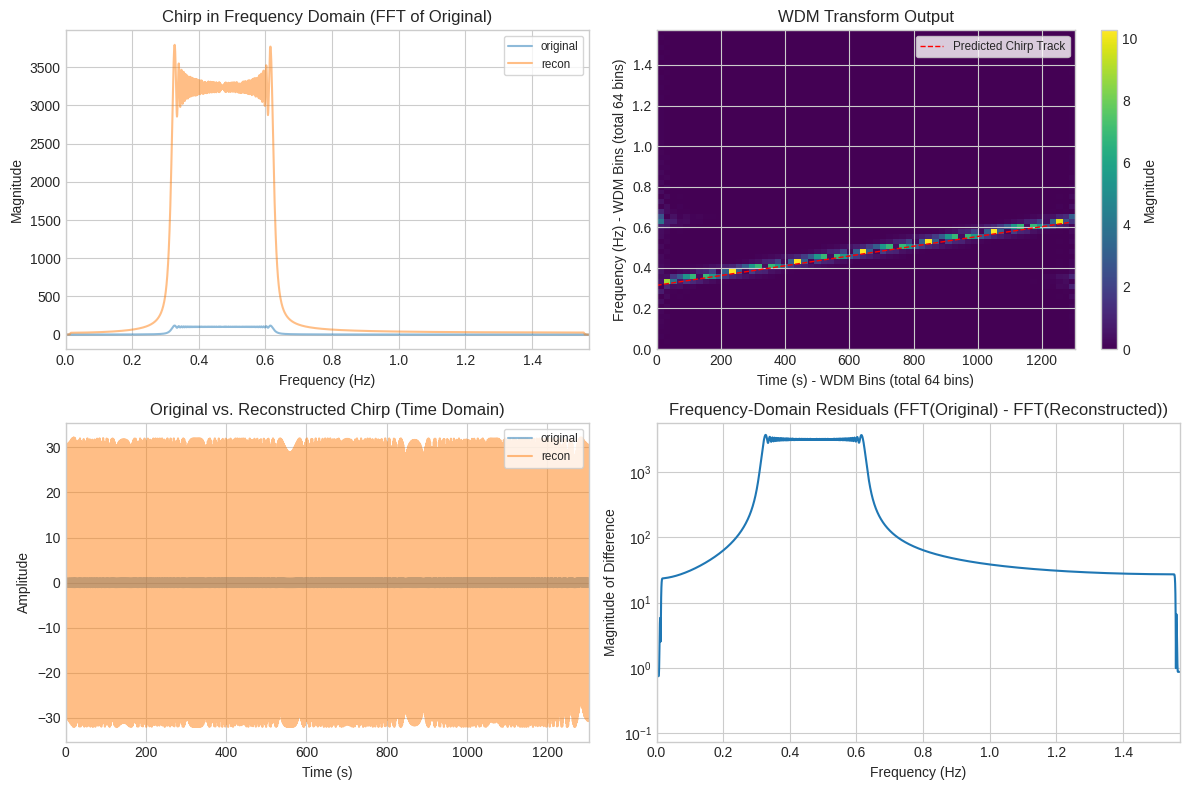


--- Running Single Element Inverse Reconstruction Test ---


<ipython-input-2-6a610422fc9c>:180: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,3, figsize=(6,4))


Single element reconstruction FAILED for 32 cases:
  Index (t,f)=(0,1), max_abs_diff=1.50e+01
  Index (t,f)=(1,1), max_abs_diff=1.50e+01
  Index (t,f)=(2,1), max_abs_diff=1.50e+01
  Index (t,f)=(3,1), max_abs_diff=1.50e+01
  Index (t,f)=(4,1), max_abs_diff=1.50e+01
Single Element Inverse Reconstruction Test FAILED overall (see details above).


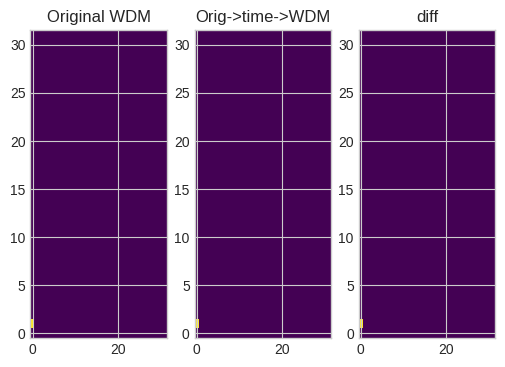

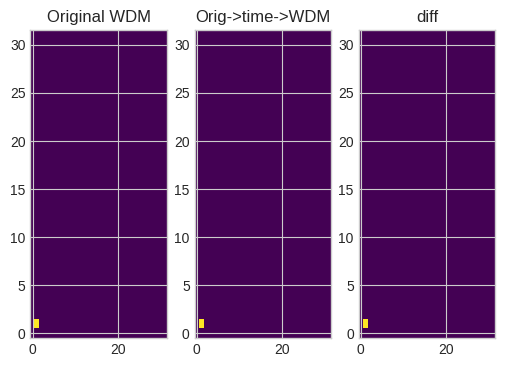

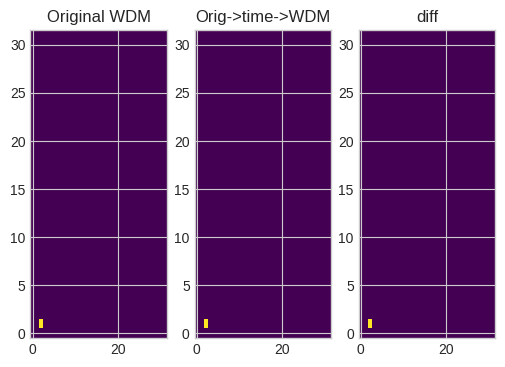

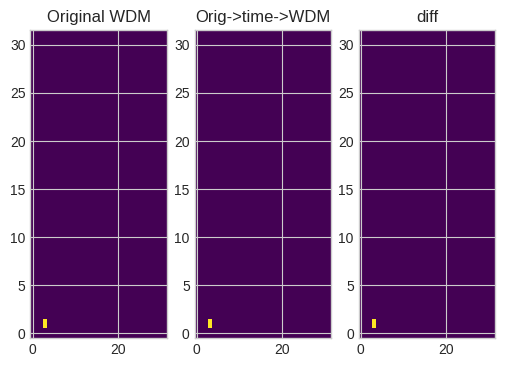

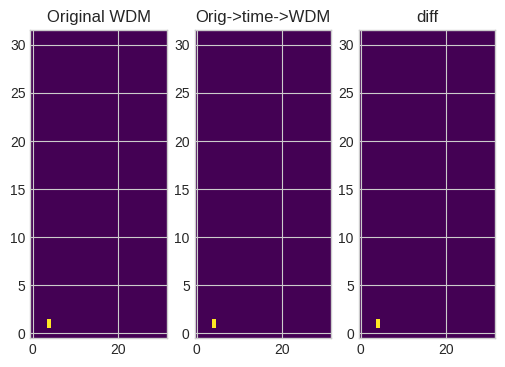

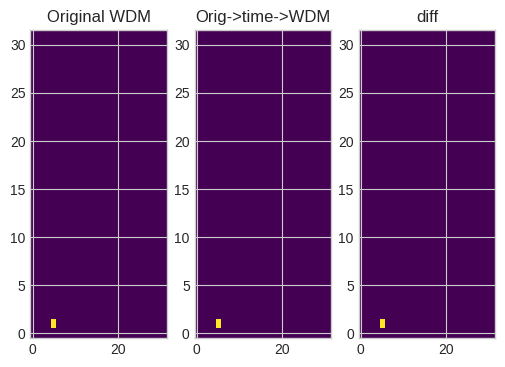

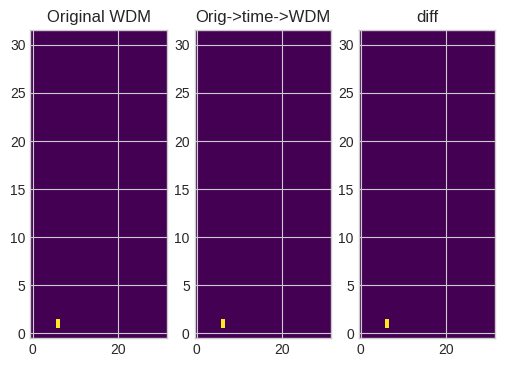

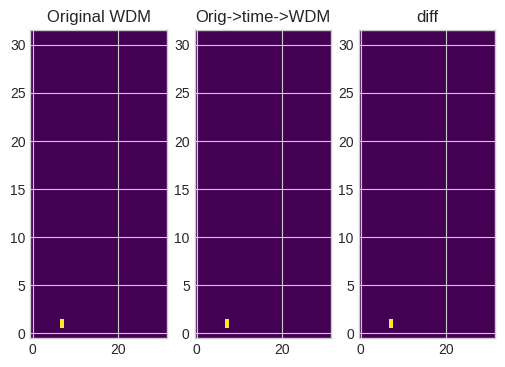

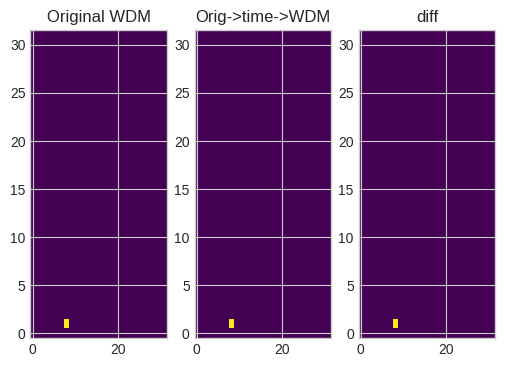

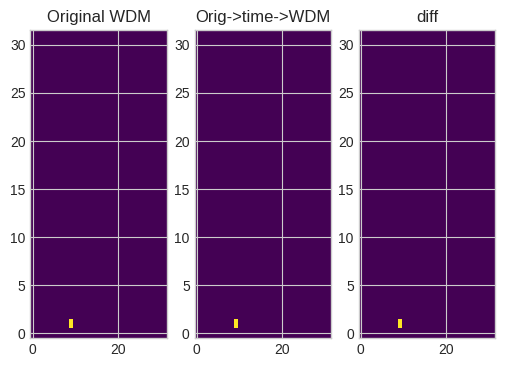

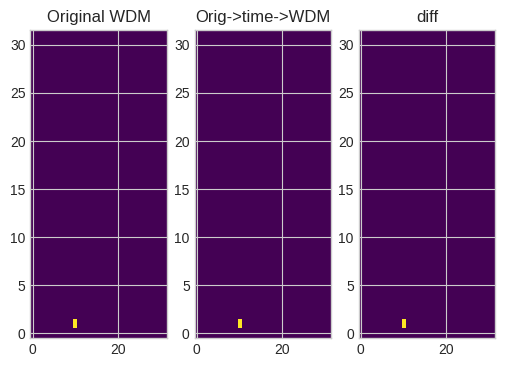

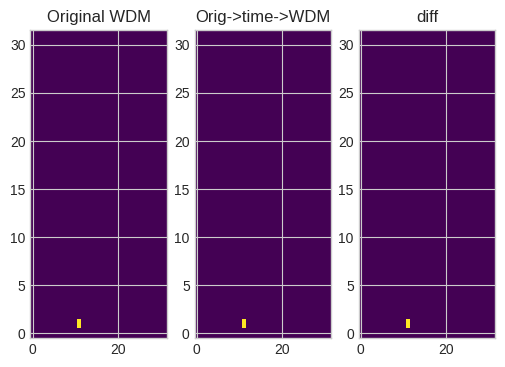

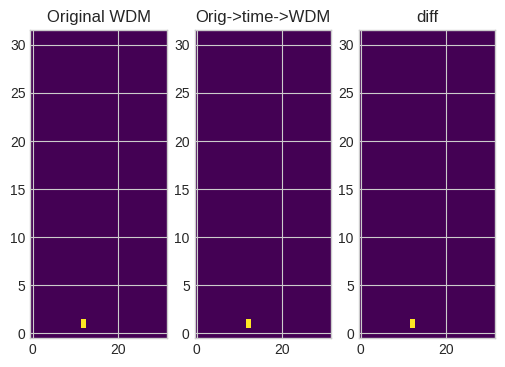

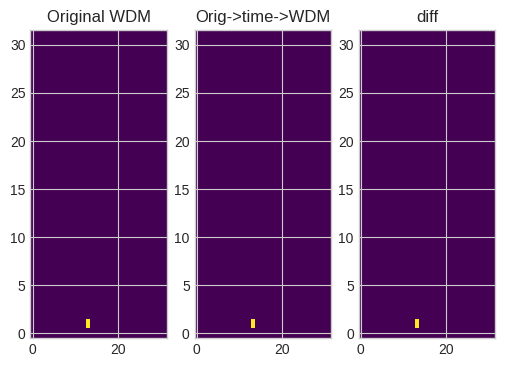

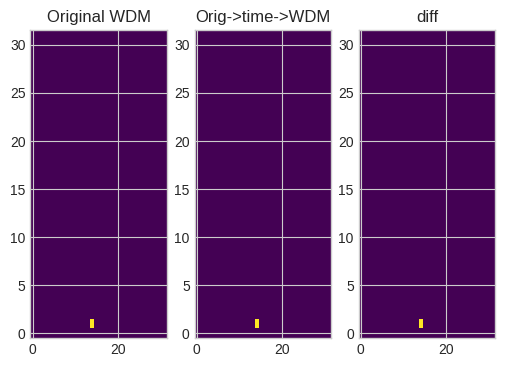

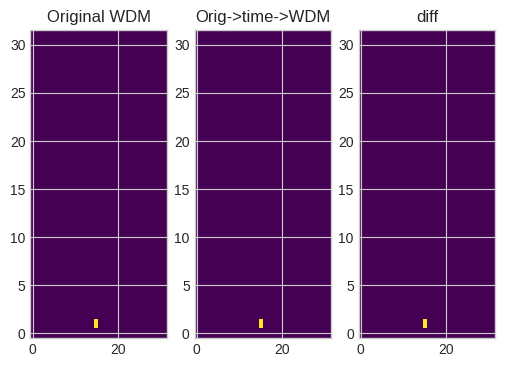

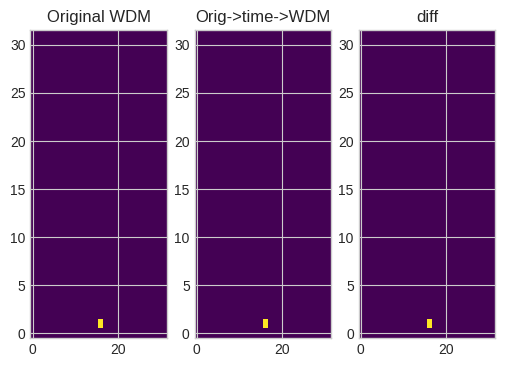

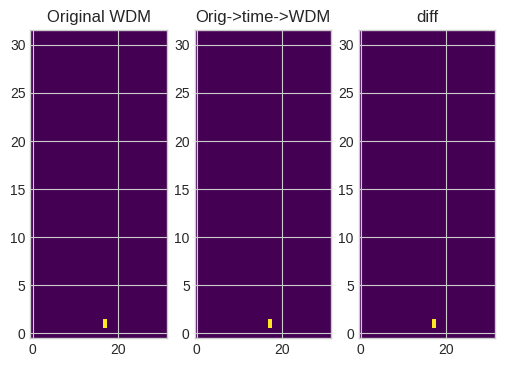

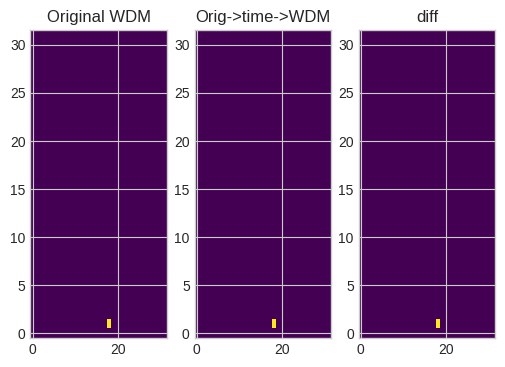

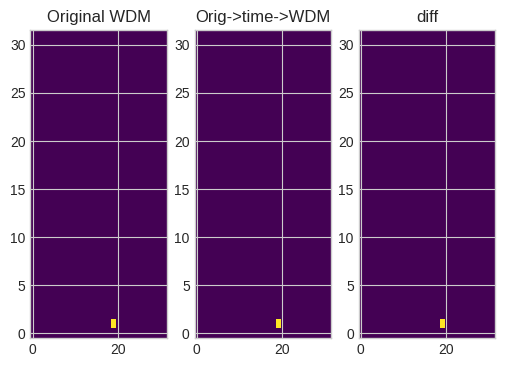

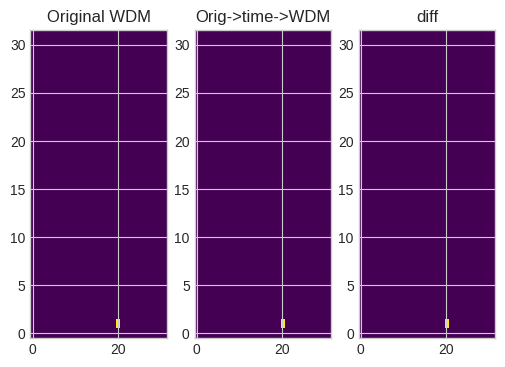

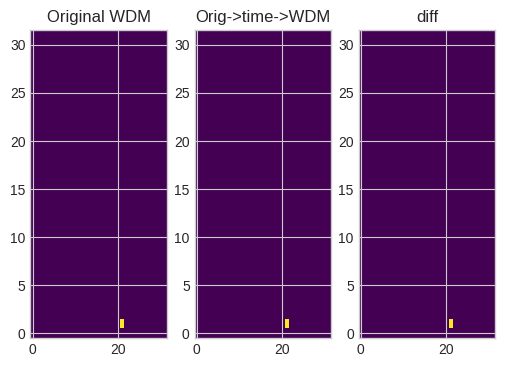

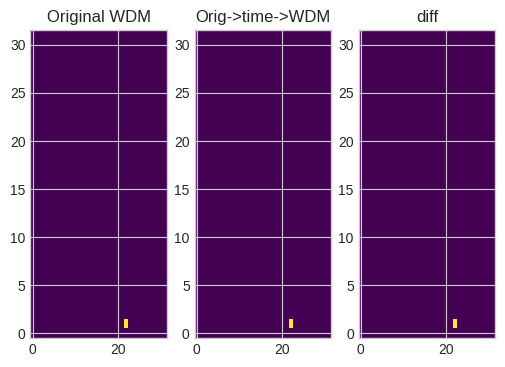

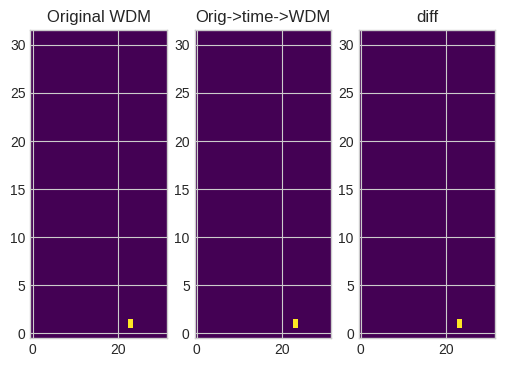

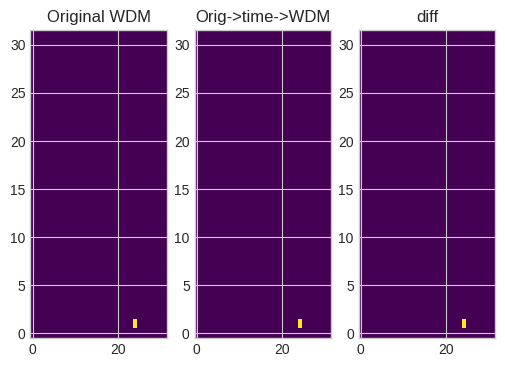

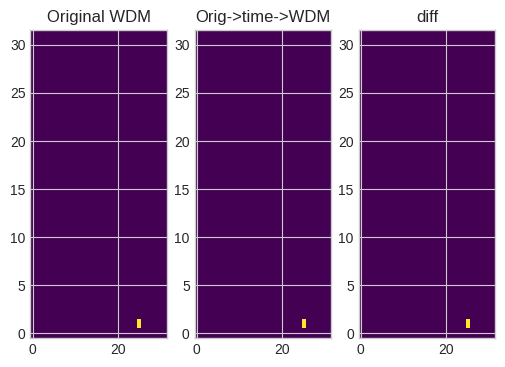

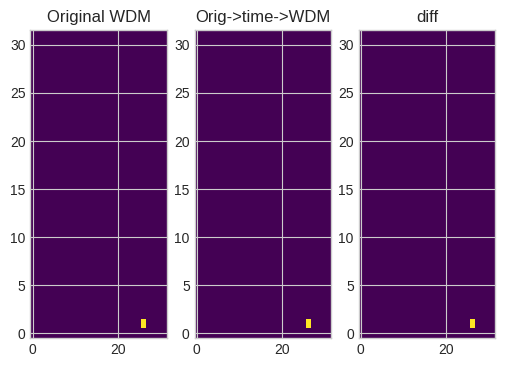

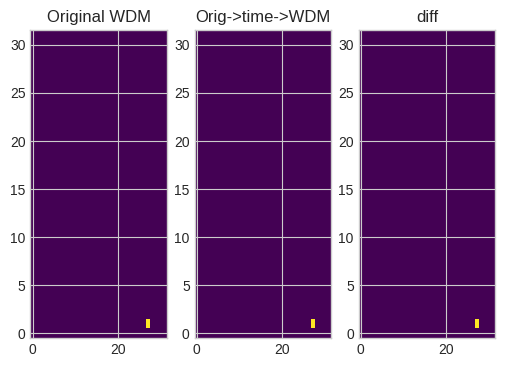

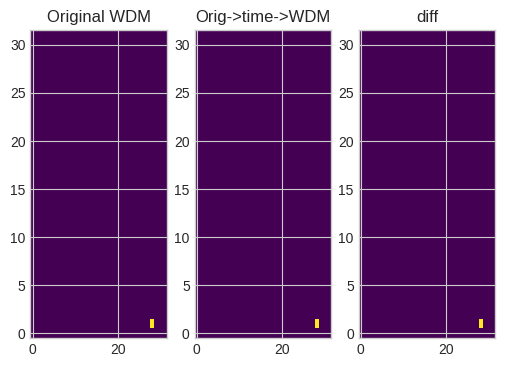

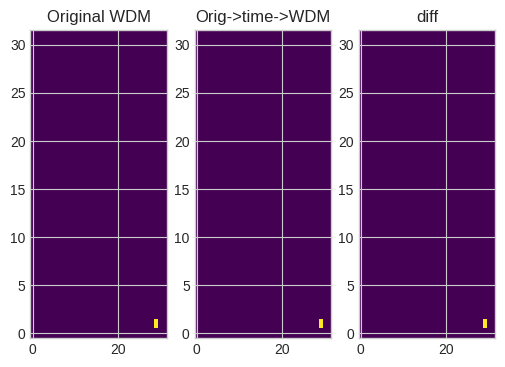

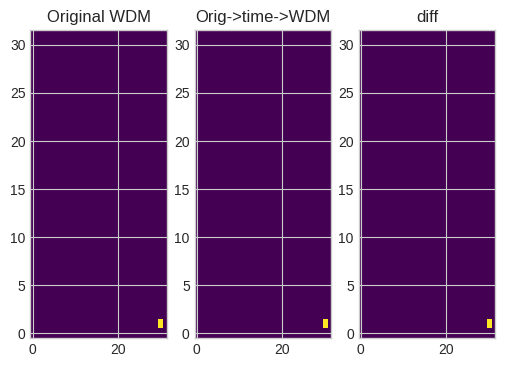

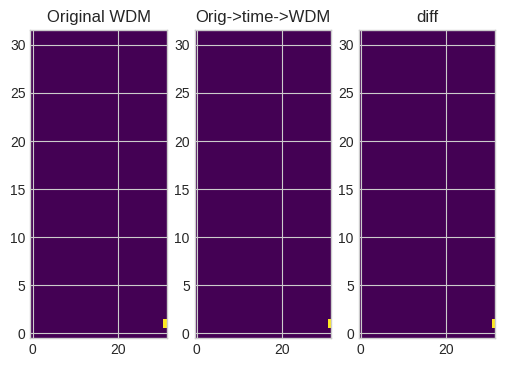

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')

# --- Test Functions and Classes ---
def chirp_signal(ts, Ac, As, f, fdot):
    """Generates a chirp signal."""
    phases = 2 * np.pi * ts * (f + fdot * ts / 2.0)
    return Ac * np.cos(phases) + As * np.sin(phases)

A_wavelet_param = 0.25 # Global for tests,
d_wavelet_param = 4    # Global for tests

def run_parsevals_theorem_and_chirp_track_test():
    """Runs Parseval's theorem and chirp tracking tests, printing results and plotting."""
    print("\n--- Running Parseval's Theorem and Chirp Track Test ---")
    dt = 1.0 / np.pi # Sampling interval of original signal
    fny = 1.0 / (2.0 * dt) # Nyquist frequency

    nt = 64 # WDM time bins
    nf = 64 # WDM frequency bins
    n_total = nt * nf # Total samples in original signal

    ts_signal = dt * np.arange(n_total) # Time vector for original signal
    T_duration = n_total * dt # Total duration of original signal

    f0 = fny / 5.0 # Initial frequency of chirp
    fdot = f0 / T_duration # Rate of change of frequency

    Amplitude = 1.0
    rng = np.random.default_rng(seed=42)
    phi_chirp = np.arctan2(rng.standard_normal(), rng.standard_normal())
    Ac = Amplitude * np.cos(phi_chirp)
    As = Amplitude * np.sin(phi_chirp)

    f_time_domain = chirp_signal(ts_signal, Ac, As, f0, fdot)

    # Perform WDM transform
    f_tilde_wdm = wdm_transform(f_time_domain, nt, nf, A_wavelet_param, d_wavelet_param)

    # Perform inverse WDM transform for reconstruction plots
    f_reconstructed_time = wdm_inverse_transform(f_tilde_wdm, A_wavelet_param, d_wavelet_param)


    # --- Parseval's Theorem Test ---
    sum_f_sq = np.sum(f_time_domain**2)
    sum_f_tilde_sq = np.sum(f_tilde_wdm**2)

    parseval_check = np.isclose(sum_f_sq, sum_f_tilde_sq, rtol=1e-2, atol=0)
    if not parseval_check:
        print(f"Parseval's Theorem FAILED: sum(f^2)={sum_f_sq:.4e}, sum(f_tilde^2)={sum_f_tilde_sq:.4e} (rtol=1e-2)")
    else:
        print(f"Parseval's Theorem PASSED: sum(f^2)={sum_f_sq:.4e}, sum(f_tilde^2)={sum_f_tilde_sq:.4e} (rtol=1e-2)")

    # --- Chirp Track Test ---
    dT_wdm_bin, dF_wdm_bin = wdm_dT_dF(nt, nf, dt) # WDM bin widths based on original signal dt

    max_power_indices_freq = np.argmax(np.abs(f_tilde_wdm), axis=1)

    times_for_chirp_track_pred = np.arange(nt) * dT_wdm_bin # Time for each WDM time bin
    predicted_frequencies_chirp = f0 + fdot * times_for_chirp_track_pred
    predicted_max_power_indices_freq = predicted_frequencies_chirp / dF_wdm_bin

    diff_chirp_track = np.abs(max_power_indices_freq[1:-1] - predicted_max_power_indices_freq[1:-1])
    if diff_chirp_track.size > 0:
        chirp_track_check = np.all(diff_chirp_track <= 2.5)
        max_diff_val = np.max(diff_chirp_track)
        if not chirp_track_check:
            print(f"Chirp Track FAILED: Max deviation {max_diff_val:.2f} > 2.5. Failing diffs: {diff_chirp_track[diff_chirp_track > 2.5]}")
        else:
            print(f"Chirp Track PASSED: Max deviation {max_diff_val:.2f} <= 2.5")
    elif nt <=2 :
        print("Chirp Track SKIPPED: nt is too small to evaluate edges.")
    else:
        print("Chirp Track SKIPPED: Not enough data points after excluding edges.")

    # --- Plotting ---


    orig_kwgs = dict( color='tab:blue', alpha=0.5, label='original')
    recon_kwgs = dict(color='tab:orange', alpha=0.5, label='recon')

    # 1. Chirp in Frequency Domain (FFT of original signal)
    plt.figure(figsize=(12, 8))
    original_fft = fft(f_time_domain)
    original_fft_freqs = fftfreq(n_total, d=dt)
    reconstructed_fft = fft(f_reconstructed_time)
    # Plot only positive frequencies for clarity
    positive_freq_mask = original_fft_freqs >= 0
    plt.subplot(2, 2, 1)
    plt.plot(original_fft_freqs[positive_freq_mask], np.abs(original_fft[positive_freq_mask]), **orig_kwgs)
    plt.plot(original_fft_freqs[positive_freq_mask],np.abs(reconstructed_fft[positive_freq_mask]), **recon_kwgs )
    plt.legend()
    plt.title('Chirp in Frequency Domain (FFT of Original)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend(fontsize='small', loc='upper right', frameon=True)
    plt.xlim(0, fny) # Show up to Nyquist

    # 2. WDM Transform (imshow)
    # Get actual time and frequency extents for WDM plot
    # wdm_times_xaxis are the start times of each WDM time bin
    # wdm_freqs_yaxis are the start frequencies of each WDM frequency bin
    wdm_times_xaxis, wdm_freqs_yaxis = wdm_times_frequencies(nt, nf, dt)

    plt.subplot(2, 2, 2)
    # extent: [left, right, bottom, top]
    # We want to show the full range covered by the bins
    # Time axis: from wdm_times_xaxis[0] to wdm_times_xaxis[-1] + dT_wdm_bin
    # Freq axis: from wdm_freqs_yaxis[0] to wdm_freqs_yaxis[-1] + dF_wdm_bin
    img_extent = [wdm_times_xaxis[0], wdm_times_xaxis[-1] + dT_wdm_bin,
                  wdm_freqs_yaxis[0], wdm_freqs_yaxis[-1] + dF_wdm_bin]

    # Transpose f_tilde_wdm because imshow's first index is rows (y-axis, frequency), second is columns (x-axis, time)
    # And WDM matrix is (nt_bins, nf_bins) = (time_bins, freq_bins)
    # So f_tilde_wdm is (time, freq). For imshow(M), M[row,col].
    # We want time on x-axis, freq on y-axis. So imshow(f_tilde_wdm.T)
    plt.imshow(np.abs(f_tilde_wdm.T), aspect='auto', origin='lower',
               extent=img_extent, cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.title('WDM Transform Output')
    plt.xlabel(f'Time (s) - WDM Bins (total {nt} bins)')
    plt.ylabel(f'Frequency (Hz) - WDM Bins (total {nf} bins)')
    # Plot the predicted chirp track on top
    plt.plot(times_for_chirp_track_pred, predicted_frequencies_chirp, 'r--', linewidth=1, label='Predicted Chirp Track')
    plt.legend(fontsize='small', loc='upper right', frameon=True)


    # 3. Reconstructed Chirp (Time Domain)
    plt.subplot(2, 2, 3)
    plt.plot(ts_signal, f_time_domain,  **orig_kwgs)
    plt.plot(ts_signal, f_reconstructed_time,  **recon_kwgs)
    plt.title('Original vs. Reconstructed Chirp (Time Domain)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.xlim(ts_signal[0], ts_signal[-1])
    plt.legend(fontsize='small', loc='upper right', frameon=True)

    # 4. Frequency-Domain Residuals
    freq_residuals = np.abs(original_fft - reconstructed_fft)
    plt.subplot(2, 2, 4)
    plt.plot(original_fft_freqs[positive_freq_mask], freq_residuals[positive_freq_mask])
    plt.title('Frequency-Domain Residuals (FFT(Original) - FFT(Reconstructed))')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude of Difference')
    plt.yscale('log') # Residuals can be small, log scale helps
    plt.xlim(0, fny)
    plt.ylim(bottom=max(1e-9, np.min(freq_residuals[positive_freq_mask & (freq_residuals > 0)])*0.1)) # Avoid zero for log scale

    plt.tight_layout()
    plt.show()


def run_single_element_inverse_reconstruction_test():
    """Runs round-trip transform for single element impulses, printing results."""
    print("\n--- Running Single Element Inverse Reconstruction Test ---")
    nt = 32
    nf = 32

    reconstruction_failures = []
    all_passed = True

    for i in range(nt):
        for j in range(1, nf):
            x_original_wdm = np.zeros((nt, nf))
            x_original_wdm[i, j] = 1.0

            time_signal_from_single_coeff = wdm_inverse_direct(x_original_wdm, A_wavelet_param, d_wavelet_param)

            x_reconstructed_wdm = wdm_transform(time_signal_from_single_coeff, nt, nf, A_wavelet_param, d_wavelet_param)

            if not np.allclose(x_original_wdm, x_reconstructed_wdm, atol=1e-7):
                diff_wdm = np.abs(x_original_wdm - x_reconstructed_wdm)
                diff_val = np.max(diff_wdm)
                reconstruction_failures.append(((i,j), diff_val))
                all_passed = False

                fig, ax = plt.subplots(1,3, figsize=(6,4))
                ax[0].imshow(np.abs(x_original_wdm.T), aspect='auto', origin='lower',  cmap='viridis')
                ax[1].imshow(np.abs(x_reconstructed_wdm.T), aspect='auto', origin='lower',  cmap='viridis')
                ax[2].imshow(diff_wdm.T, aspect='auto', origin='lower',  cmap='viridis')
                ax[0].set_title("Original WDM")
                ax[1].set_title("Orig->time->WDM")
                ax[2].set_title("diff")
                break

    if reconstruction_failures:
        print(f"Single element reconstruction FAILED for {len(reconstruction_failures)} cases:")
        for k_idx in range(min(5, len(reconstruction_failures))):
            print(f"  Index (t,f)=({reconstruction_failures[k_idx][0][0]},{reconstruction_failures[k_idx][0][1]}), max_abs_diff={reconstruction_failures[k_idx][1]:.2e}")

    if all_passed:
        print("Single Element Inverse Reconstruction Test PASSED for all elements.")
    else:
        print("Single Element Inverse Reconstruction Test FAILED overall (see details above).")
    return all_passed




if __name__ == '__main__':
    run_parsevals_theorem_and_chirp_track_test()
    run_single_element_inverse_reconstruction_test()





In [26]:
i, j = 2, 2
nf, nt = 4, 4
x_original_wdm = np.zeros((nt, nf))
x_original_wdm[i, j] = 1.0

time_signal_from_single_coeff = wdm_inverse_direct(x_original_wdm, A_wavelet_param, d_wavelet_param)
x_reconstructed_wdm = wdm_transform(time_signal_from_single_coeff, nt, nf, A_wavelet_param, d_wavelet_param)

print("Orig WDM: \n",  x_original_wdm)

new = x_reconstructed_wdm.copy()
new[new<1e-10]=0
print("New WDM: \n", new)

Orig WDM: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]
New WDM: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]]
